# Similarity scorres and recommendation 

Loading processed data...
Loaded 1682 fuzzy movies from movies_fuzzy.csv
Loaded 100000 ratings
Loaded 10 user profiles
Data loading complete

Fuzzy movies data check:
Fuzzy movies shape: (1682, 20)
Sample genre 'Action' value range: 0.000 to 0.998
Similarity and recommendation engine implementation complete
Preparing user profiles...
Prepared 10 user profiles

Sample user profile:
User ID: 196.0
Total ratings: 39.0
Average rating: 3.62

Generating recommendations...

Processing user 196.0...
User has rated 39 movies
Generating recommendations for user 196.0 from 1643 unrated movies
  Processed 100/1643 movies...
  Processed 200/1643 movies...
  Processed 300/1643 movies...
  Processed 400/1643 movies...
  Processed 500/1643 movies...
  Processed 600/1643 movies...
  Processed 700/1643 movies...
  Processed 800/1643 movies...
  Processed 900/1643 movies...
  Processed 1000/1643 movies...
  Processed 1100/1643 movies...
  Processed 1200/1643 movies...
  Processed 1300/1643 movies...
  Pr

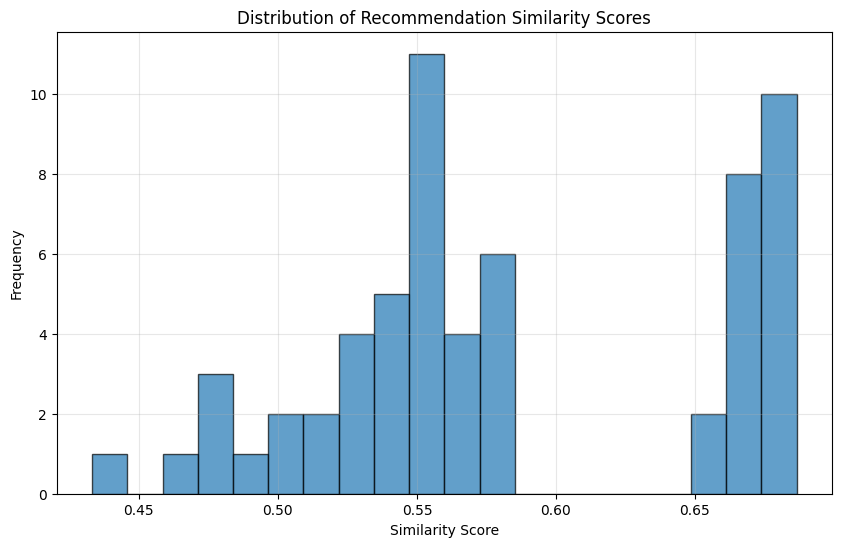


Genre Alignment Analysis:
Top genre alignment in recommendations:
  Comedy: 20 recommendations (33.3%)
  Thriller: 19 recommendations (31.7%)
  Action: 17 recommendations (28.3%)

Saving recommendations...
Recommendations saved to: /Users/mac/Desktop/granular_recommendation/results/recommendations.csv

Recommendation System Performance Summary:
Users processed: 3
Regular recommendations generated: 30
Diverse recommendations generated: 30
Total recommendations: 60
Average similarity score: 0.582

Implemented granular fuzzy similarity measures
Generated personalized recommendations using fuzzy logic
Applied MMR diversification for recommendation variety


In [1]:
# Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

# Configuration and Data Loading
class Config:
    PROJECT_ROOT = Path.cwd().parent
    DATA_DIR = PROJECT_ROOT / "data"
    PROCESSED_DATA_DIR = DATA_DIR / "processed"
    RESULTS_DIR = PROJECT_ROOT / "results"
    
    GENRES = [
        'unknown', 'Action', 'Adventure', 'Animation', 
        'Children\'s', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
        'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
        'Thriller', 'War', 'Western'
    ]
    
    @classmethod
    def setup_directories(cls):
        directories = [cls.RESULTS_DIR]
        for directory in directories:
            directory.mkdir(parents=True, exist_ok=True)

Config.setup_directories()

print("Loading processed data...")
try:
    fuzzy_movies_path_1 = Config.PROCESSED_DATA_DIR / 'movies_fuzzy.csv'
    fuzzy_movies_path_2 = Config.PROCESSED_DATA_DIR / 'fuzzy_movies.csv'
    
    if fuzzy_movies_path_1.exists():
        fuzzy_movies_df = pd.read_csv(fuzzy_movies_path_1)
        print(f"Loaded {len(fuzzy_movies_df)} fuzzy movies from movies_fuzzy.csv")
    elif fuzzy_movies_path_2.exists():
        fuzzy_movies_df = pd.read_csv(fuzzy_movies_path_2)
        print(f"Loaded {len(fuzzy_movies_df)} fuzzy movies from fuzzy_movies.csv")
    else:
        print("Available files:", list(Config.PROCESSED_DATA_DIR.glob('*fuzzy*')))
        raise FileNotFoundError("No fuzzy movies file found")
    
    ratings_path = Config.PROCESSED_DATA_DIR / 'ratings_processed.csv'
    ratings_df = pd.read_csv(ratings_path)
    print(f"Loaded {len(ratings_df)} ratings")
    
    profiles_path = Config.RESULTS_DIR / 'user_profiles.csv'
    user_profiles_df = pd.read_csv(profiles_path)
    print(f"Loaded {len(user_profiles_df)} user profiles")
    
except Exception as e:
    print(f"Error loading data: {e}")
    raise

print("Data loading complete")

print("\nFuzzy movies data check:")
print(f"Fuzzy movies shape: {fuzzy_movies_df.shape}")
genre_cols = [col for col in fuzzy_movies_df.columns if col in Config.GENRES and col != 'unknown']
if genre_cols:
    sample_genre = genre_cols[0]
    print(f"Sample genre '{sample_genre}' value range: {fuzzy_movies_df[sample_genre].min():.3f} to {fuzzy_movies_df[sample_genre].max():.3f}")

# Granular Similarity Implementation
class FuzzySimilarity:
    """Calculate fuzzy similarity measures between user profiles and movies"""
    
    def __init__(self):
        self.config = Config()
    
    def normalize_genre_name(self, genre_name):
        if genre_name.startswith('pref_'):
            return genre_name[5:]
        return genre_name
    
    def get_user_genre_value(self, user_profile, genre):
        if genre in user_profile:
            return float(user_profile[genre])
        
        pref_genre = f"pref_{genre}"
        if pref_genre in user_profile:
            return float(user_profile[pref_genre])
        
        for user_key in user_profile:
            normalized_key = self.normalize_genre_name(user_key)
            if normalized_key == genre:
                return float(user_profile[user_key])
        
        return 0.0
    
    def fuzzy_jaccard(self, user_profile, movie_profile):
        intersection = 0.0
        union = 0.0
        
        for genre in self.config.GENRES:
            if genre == 'unknown':
                continue
                
            user_val = self.get_user_genre_value(user_profile, genre)
            movie_val = movie_profile.get(genre, 0.0)
            
            user_val = float(user_val) if pd.notna(user_val) else 0.0
            movie_val = float(movie_val) if pd.notna(movie_val) else 0.0
            
            intersection += min(user_val, movie_val)
            union += max(user_val, movie_val)
        
        result = intersection / union if union > 0 else 0.0
        return result
    
    def fuzzy_cosine(self, user_profile, movie_profile):
        dot_product = 0.0
        user_norm = 0.0
        movie_norm = 0.0
        
        for genre in self.config.GENRES:
            if genre == 'unknown':
                continue
                
            user_val = self.get_user_genre_value(user_profile, genre)
            movie_val = movie_profile.get(genre, 0.0)
            
            user_val = float(user_val) if pd.notna(user_val) else 0.0
            movie_val = float(movie_val) if pd.notna(movie_val) else 0.0
            
            dot_product += user_val * movie_val
            user_norm += user_val ** 2
            movie_norm += movie_val ** 2
        
        user_norm = np.sqrt(user_norm) if user_norm > 0 else 1.0
        movie_norm = np.sqrt(movie_norm) if movie_norm > 0 else 1.0
        
        return dot_product / (user_norm * movie_norm)
    
    def fuzzy_dice(self, user_profile, movie_profile):
        intersection = 0.0
        sum_profiles = 0.0
        
        for genre in self.config.GENRES:
            if genre == 'unknown':
                continue
                
            user_val = self.get_user_genre_value(user_profile, genre)
            movie_val = movie_profile.get(genre, 0.0)
            
            user_val = float(user_val) if pd.notna(user_val) else 0.0
            movie_val = float(movie_val) if pd.notna(movie_val) else 0.0
            
            intersection += min(user_val, movie_val)
            sum_profiles += user_val + movie_val
        
        return (2 * intersection) / sum_profiles if sum_profiles > 0 else 0.0
    
    def hybrid_similarity(self, user_profile, movie_profile, weights=None):
        if weights is None:
            weights = {'jaccard': 0.4, 'cosine': 0.4, 'dice': 0.2}
        
        jaccard = self.fuzzy_jaccard(user_profile, movie_profile)
        cosine = self.fuzzy_cosine(user_profile, movie_profile)
        dice = self.fuzzy_dice(user_profile, movie_profile)
        
        hybrid = (weights['jaccard'] * jaccard + 
                 weights['cosine'] * cosine + 
                 weights['dice'] * dice)
        
        return hybrid

# Recommendation Engine Implementation
class FuzzyRecommender:
    """Fuzzy logic-based movie recommendation system"""
    
    def __init__(self):
        self.config = Config()
        self.similarity = FuzzySimilarity()
    
    def generate_recommendations(self, user_profile_dict, fuzzy_movies_df, user_rated_movies, top_n=10):
        recommendations = []
        
        user_id = user_profile_dict['user_id']
        user_preferences = user_profile_dict['profile_dict']
        
        unrated_movies = fuzzy_movies_df[~fuzzy_movies_df['movie_id'].isin(user_rated_movies)]
        
        print(f"Generating recommendations for user {user_id} from {len(unrated_movies)} unrated movies")
        
        processed_count = 0
        for idx, movie in unrated_movies.iterrows():
            movie_profile = {}
            for genre in self.config.GENRES:
                if genre != 'unknown' and genre in movie:
                    movie_profile[genre] = movie[genre]
            
            similarity_score = self.similarity.hybrid_similarity(user_preferences, movie_profile)
            
            if similarity_score > 0.01:
                movie_genres = []
                for genre in self.config.GENRES:
                    if genre != 'unknown' and genre in movie_profile and movie_profile[genre] > 0.1:
                        movie_genres.append((genre, movie_profile[genre]))
                
                movie_genres.sort(key=lambda x: x[1], reverse=True)
                top_movie_genres = movie_genres[:3]
                
                recommendations.append({
                    'movie_id': movie['movie_id'],
                    'title': movie['title'],
                    'similarity_score': similarity_score,
                    'genres': top_movie_genres
                })
            
            processed_count += 1
            if processed_count % 100 == 0:
                print(f"  Processed {processed_count}/{len(unrated_movies)} movies...")
        
        recommendations.sort(key=lambda x: x['similarity_score'], reverse=True)
        
        print(f"  Found {len(recommendations)} movies with similarity > 0.01")
        return recommendations[:top_n]
    
    def generate_diverse_recommendations(self, user_profile_dict, fuzzy_movies_df, user_rated_movies, 
                                      top_n=10, diversity_factor=0.3):
        recommendations = self.generate_recommendations(
            user_profile_dict, fuzzy_movies_df, user_rated_movies, top_n=50
        )
        
        if not recommendations or len(recommendations) <= 1:
            return recommendations[:top_n]
        
        diverse_recommendations = []
        remaining_recommendations = recommendations.copy()
        
        diverse_recommendations.append(remaining_recommendations.pop(0))
        
        while len(diverse_recommendations) < top_n and remaining_recommendations:
            best_score = -1
            best_index = -1
            
            for i, candidate in enumerate(remaining_recommendations):
                relevance = candidate['similarity_score']
                max_similarity = 0
                
                for selected in diverse_recommendations:
                    selected_genres = set([g for g, s in selected['genres']])
                    candidate_genres = set([g for g, s in candidate['genres']])
                    overlap = len(selected_genres.intersection(candidate_genres))
                    total_genres = max(len(selected_genres), len(candidate_genres))
                    similarity = overlap / total_genres if total_genres > 0 else 0
                    max_similarity = max(max_similarity, similarity)
                
                mmr_score = relevance - diversity_factor * max_similarity
                
                if mmr_score > best_score:
                    best_score = mmr_score
                    best_index = i
            
            if best_index >= 0:
                diverse_recommendations.append(remaining_recommendations.pop(best_index))
            else:
                break
        
        return diverse_recommendations[:top_n]

print("Similarity and recommendation engine implementation complete")

# User Profile Preparation
print("Preparing user profiles...")

def prepare_user_profiles(user_profiles_df):
    user_profiles = []
    
    for _, row in user_profiles_df.iterrows():
        user_id = row['user_id']
        profile_dict = {}
        
        for col in row.index:
            if col.startswith('pref_') and col != 'pref_unknown':
                value = row[col]
                if pd.isna(value):
                    profile_dict[col] = 0.0
                else:
                    try:
                        profile_dict[col] = float(value)
                    except (ValueError, TypeError):
                        profile_dict[col] = 0.0
        
        user_profiles.append({
            'user_id': user_id,
            'total_ratings': row.get('total_ratings', 0),
            'average_rating': row.get('average_rating', 0),
            'profile_dict': profile_dict
        })
    
    return user_profiles

user_profiles = prepare_user_profiles(user_profiles_df)
print(f"Prepared {len(user_profiles)} user profiles")

if user_profiles:
    sample_profile = user_profiles[0]
    print(f"\nSample user profile:")
    print(f"User ID: {sample_profile['user_id']}")
    print(f"Total ratings: {sample_profile['total_ratings']}")
    print(f"Average rating: {sample_profile['average_rating']:.2f}")

# Generate Recommendations
print("\nGenerating recommendations...")
recommender = FuzzyRecommender()

test_users = user_profiles[:3]
all_recommendations = {}

for user_profile in test_users:
    user_id = user_profile['user_id']
    user_rated_movies = ratings_df[ratings_df['user_id'] == user_id]['movie_id'].tolist()
    
    print(f"\nProcessing user {user_id}...")
    print(f"User has rated {len(user_rated_movies)} movies")
    
    regular_recs = recommender.generate_recommendations(
        user_profile, fuzzy_movies_df, user_rated_movies, top_n=10
    )
    
    diverse_recs = recommender.generate_diverse_recommendations(
        user_profile, fuzzy_movies_df, user_rated_movies, top_n=10
    )
    
    all_recommendations[user_id] = {
        'regular': regular_recs,
        'diverse': diverse_recs,
        'user_profile': user_profile
    }
    
    print(f"Generated {len(regular_recs)} regular and {len(diverse_recs)} diverse recommendations")

# Display Recommendation Results
print("\nRecommendation Results:")

for user_id, rec_data in all_recommendations.items():
    user_profile = rec_data['user_profile']
    regular_recs = rec_data['regular']
    diverse_recs = rec_data['diverse']
    
    print(f"\nUser {user_id} Recommendations")
    print(f"Ratings: {user_profile['total_ratings']}, Avg Rating: {user_profile['average_rating']:.2f}")
    
    print(f"Top Regular Recommendations:")
    for i, rec in enumerate(regular_recs[:3], 1):
        genres_str = ', '.join([f'{g}({s:.2f})' for g, s in rec['genres'][:2]])
        print(f"  {i}. {rec['title']}")
        print(f"     Score: {rec['similarity_score']:.3f} | Genres: {genres_str}")
    
    print(f"Diverse Recommendations:")
    for i, rec in enumerate(diverse_recs[:3], 1):
        genres_str = ', '.join([f'{g}({s:.2f})' for g, s in rec['genres'][:2]])
        print(f"  {i}. {rec['title']}")
        print(f"     Score: {rec['similarity_score']:.3f} | Genres: {genres_str}")

# Similarity Analysis
print("\nSimilarity Analysis:")

similarity_scores = []
for user_id, rec_data in all_recommendations.items():
    for rec_type in ['regular', 'diverse']:
        for rec in rec_data[rec_type]:
            similarity_scores.append(rec['similarity_score'])

if similarity_scores:
    similarity_scores = np.array(similarity_scores)
    print(f"Similarity score statistics:")
    print(f"  Mean: {similarity_scores.mean():.3f}")
    print(f"  Std:  {similarity_scores.std():.3f}")
    print(f"  Min:  {similarity_scores.min():.3f}")
    print(f"  Max:  {similarity_scores.max():.3f}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(similarity_scores, bins=20, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Recommendation Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("No similarity scores available")

# Genre Alignment Analysis
print("\nGenre Alignment Analysis:")

genre_alignment = {genre: 0 for genre in Config.GENRES if genre != 'unknown'}
total_recommendations = 0

for user_id, rec_data in all_recommendations.items():
    user_profile = rec_data['user_profile']
    user_prefs = user_profile['profile_dict']
    
    non_zero_prefs = {k: v for k, v in user_prefs.items() if v > 0}
    if non_zero_prefs:
        user_top_genre_full = max(non_zero_prefs.items(), key=lambda x: x[1])[0]
        user_top_genre = user_top_genre_full[5:] if user_top_genre_full.startswith('pref_') else user_top_genre_full
    else:
        user_top_genre = None
    
    for rec_type in ['regular', 'diverse']:
        for rec in rec_data[rec_type]:
            total_recommendations += 1
            if user_top_genre:
                rec_genres = [g for g, s in rec['genres']]
                if user_top_genre in rec_genres:
                    genre_alignment[user_top_genre] += 1

print("Top genre alignment in recommendations:")
for genre, count in sorted(genre_alignment.items(), key=lambda x: x[1], reverse=True):
    if count > 0:
        alignment_rate = count / total_recommendations * 100
        print(f"  {genre}: {count} recommendations ({alignment_rate:.1f}%)")

# Save Recommendations
print("\nSaving recommendations...")

recommendations_data = []
for user_id, rec_data in all_recommendations.items():
    for rec_type in ['regular', 'diverse']:
        for rec in rec_data[rec_type]:
            recommendations_data.append({
                'user_id': user_id,
                'recommendation_type': rec_type,
                'movie_id': rec['movie_id'],
                'title': rec['title'],
                'similarity_score': rec['similarity_score'],
                'top_genres': ';'.join([f"{g}:{s:.2f}" for g, s in rec['genres']])
            })

recommendations_df = pd.DataFrame(recommendations_data)
recommendations_path = Config.RESULTS_DIR / 'recommendations.csv'
recommendations_df.to_csv(recommendations_path, index=False)
print(f"Recommendations saved to: {recommendations_path}")

# System Performance Summary
print("\nRecommendation System Performance Summary:")

total_users = len(all_recommendations)
total_regular_recs = sum(len(data['regular']) for data in all_recommendations.values())
total_diverse_recs = sum(len(data['diverse']) for data in all_recommendations.values())

print(f"Users processed: {total_users}")
print(f"Regular recommendations generated: {total_regular_recs}")
print(f"Diverse recommendations generated: {total_diverse_recs}")
print(f"Total recommendations: {total_regular_recs + total_diverse_recs}")

if len(similarity_scores) > 0:
    print(f"Average similarity score: {similarity_scores.mean():.3f}")

print(f"\nImplemented granular fuzzy similarity measures")
print(f"Generated personalized recommendations using fuzzy logic")
print(f"Applied MMR diversification for recommendation variety")